<a href="https://colab.research.google.com/github/EmYassir/ml_dl_algorithms/blob/main/DT_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo 10 : Decision 🌳s



In this demo, you will implement:
- training a decision tree
- different methods for training a random forest

## Prepare the data

We will use the Iris dataset again. Start by loading the data and splitting it into train/test sets.


In [14]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets

iris = datasets.load_iris()

# Split into train/test
# Sépare en entrainement/test
from sklearn.model_selection import train_test_split

(iris_train_x, iris_test_x, 
 iris_train_y, iris_test_y) = train_test_split(iris.data, iris.target, test_size=100)

print(iris_train_x.shape)
print(iris_test_x.shape)

(50, 4)
(100, 4)


## Decision tree

To implement the basic decision tree, we will first implement some helper functions.


In [15]:
from collections import Counter

def get_majority_class(labels):
    # This function should return the most common label
    # in the input array.
    counts = Counter(labels)
    return counts.most_common(1)[0][0]

def compute_entropy(labels):
    counts = Counter(labels)
    counts = np.array([counts[key] for key in counts])
    frequencies = counts/counts.sum()
    entropy = -(frequencies * np.log2(frequencies)).sum()
    return entropy

example_labels = np.array([3,1,2,0,2])
print(get_majority_class(example_labels)) # should be 2
print(compute_entropy(example_labels)) # should be 1.9219280948873623

2
1.9219280948873623


Let's write a **Node** class to use in the decision tree. A node in the tree can:
- ask a question (= determine whether examples have a certain feature greater than a certain threshold),
- find the best question to split a (subset of a) dataset, or
- if it is a leaf node, predict an output.

To find the best question for one feature, compute all the **midpoints** of that feature, and for each midpoint, compute the entropy of the resulting split when the question uses that midpoint. To find the best question overall, repeat this for all columns, and pick the best question.

For example, let's say you have this dataset:

```
array([[ 0.94, -1.45, -0.1 ,  1.26],
       [-0.4 ,  0.94,  0.69,  1.53],
       [-0.38, -0.53,  1.85, -0.89]])
```

The second column has the values `-1.45, 0.94, -0.53`. Sorting these values gives us `-1.45, -0.53,  0.94`. If we take the midpoints of these values, we get `-0.99, 0.21`.

In [16]:
class Node():
    def __init__(self):
        self.threshold = None
        self.col = None
        self.is_leaf = None
        self.output_class = None
        self.left_child=None
        self.right_child=None
        
    def find_best_question(self, x, y):
        # x: np array of shape (number of examples, number of features)
        # y: np array of shape (number of examples,)
        #
        # x: tableau numpy de dimension (nombre d'exemples, nombre d'attributs)
        # y: tableau numpy de dimension (nombre d'exemples,)
        best_col = 0
        best_val = 0
        best_loss = np.inf
        
        num_cols = x.shape[1]
        valid_cols = np.arange(num_cols)
        for col in valid_cols:
            #
            # Compute the midpoints of this column's values here
            #
            sorted_indices = x[:, col].argsort()
            sorted_vals = x[sorted_indices, col]
            midpoints = [(sorted_vals[i] + sorted_vals[i+1])/2 for i in range(len(sorted_vals)-1) ]
            for val in midpoints:
                #
                # Using col and val, split the labels
                # into left_labels, right_labels here
                #
                right_subset_rows = x[:, col] > val 
                left_subset_rows = np.invert(right_subset_rows)
                right_labels = y[right_subset_rows]
                left_labels = y[left_subset_rows]
                
                right_entropy = compute_entropy(right_labels)
                left_entropy = compute_entropy(left_labels)
                loss = left_entropy + right_entropy
                if right_labels.shape[0] == 0 or left_labels.shape[0] == 0:
                    continue
                
                if loss < best_loss:
                    best_loss = loss
                    best_col = col
                    best_val = val
                    
        self.col = best_col
        self.threshold = best_val
    
    def ask_question(self, x):
        if not self.is_leaf:
            return x[:, self.col] > self.threshold
        else:
            print("Error: leaf nodes cannot ask questions!")
            return False
    
    def predict(self):
        if self.is_leaf:
            return self.output_class
        else:
            print("Error: non-leaf nodes cannot make a prediction!")
            return None

node=Node()
example_x = np.array([[-2.32,  2.02,  0.53,  0.34],
       [-1.44,  1.36,  0.12, -0.44],
       [-0.28, -0.08,  0.9 , -1.63],
       [-0.09,  0.17, -0.28,  0.44],
       [ 0.8 , -1.65,  1.36,  1.62]])
example_y = np.array([3,1,2,0,2])

# Test find_best_question()
node.find_best_question(example_x, example_y)
print(node.threshold) # should be -1.88
print(node.col) # should be 0

# Test ask_question()
test_x = np.array([[ 1.05, -1.85, -2.24,  1.45],
       [ 1.2 , -0.34,  1.54, -0.39]])
print(node.ask_question(test_x)) # should be [True True]

-1.88
0
[ True  True]


Now, using the Node class, we will implement the decision tree. Like scikit-learn's interface, we will have fit() and predict() methods.

In [17]:
class DecisionTreeClassifier():
    def __init__(self, max_depth=1):
        self.max_depth = max_depth
    
    def create_node(self, x_subset, y_subset, depth):
        # Recursive function
        node = Node()
        
        majority_class = get_majority_class(y_subset)
        majority_class_count = (y_subset == majority_class).sum()
        perfectly_classified = majority_class_count == len(y_subset)
        
        if perfectly_classified or depth == self.max_depth:
            node.output_class = majority_class
            node.is_leaf = True
        else:
            node.find_best_question(x_subset,y_subset)
            node.is_leaf = False
            right_subset_rows = node.ask_question(x_subset) 
            left_subset_rows = np.invert(right_subset_rows)
            #
            # Recursion: create node.left_child and node.right_child here
            #
            node.left_child = self.create_node(x_subset[left_subset_rows], y_subset[left_subset_rows],  depth+1)
            node.right_child = self.create_node(x_subset[right_subset_rows], y_subset[right_subset_rows], depth+1)
                
        return node
    
    def fit(self, x, y):
        self.root_node = self.create_node(x,y,depth=1)
    
    def predict(self, x):
        predictions = []
        
        for i in range(len(x)):
            current_node = self.root_node
            x_i = x[i].reshape(1,-1)
            done_descending_tree = False
            while not done_descending_tree:
                if current_node.is_leaf:
                    predictions.append(current_node.predict())
                    done_descending_tree = True

                else:
                    if current_node.ask_question(x_i):
                        current_node = current_node.right_child
                    else:
                        current_node = current_node.left_child

        return np.array(predictions)
        

Train a tree to test your implementation. (You can also try comparing with scikit-learn's tree implementation.)

/

Entrainez un arbre pour tester votre implémentation. (Vous pouvez aussi essayer de comparer avec l'implémentation d'arbre de scikit-learn.)

In [18]:
# import sklearn.tree
# tree = sklearn.tree.DecisionTreeClassifier(max_depth=10)
tree = DecisionTreeClassifier(max_depth=10)
tree.fit(iris_train_x, iris_train_y)
print(iris_test_y)
print(tree.predict(iris_test_x))
print("accuracy: ", (tree.predict(iris_test_x) == iris_test_y).mean() * 100, "%")

[1 2 2 0 1 1 1 2 1 0 2 1 1 1 0 1 2 2 2 2 1 1 1 1 1 0 0 1 2 1 2 2 0 2 1 2 0
 0 2 0 0 1 1 0 0 2 1 2 0 0 2 2 0 2 2 0 0 2 0 0 2 1 2 1 1 2 2 1 0 1 0 1 0 0
 0 1 2 0 0 2 0 0 2 1 1 0 0 0 2 1 1 2 1 2 1 0 1 2 2 0]
[1 2 2 0 1 1 1 2 1 0 2 1 1 1 0 1 2 2 2 2 1 1 2 1 1 0 0 1 2 1 2 2 0 2 1 2 0
 0 2 0 0 1 2 0 0 2 1 2 0 0 2 2 0 2 2 0 0 2 0 0 2 1 2 1 1 2 2 1 0 2 0 1 0 0
 0 2 2 0 0 2 0 0 2 1 1 0 0 0 2 1 1 2 1 2 1 0 1 2 2 0]
accuracy:  96.0 %


Train trees of increasing depth on the Iris dataset and plot their performance. What do you notice about the performance as the depth increases?


Best performance:  0.97


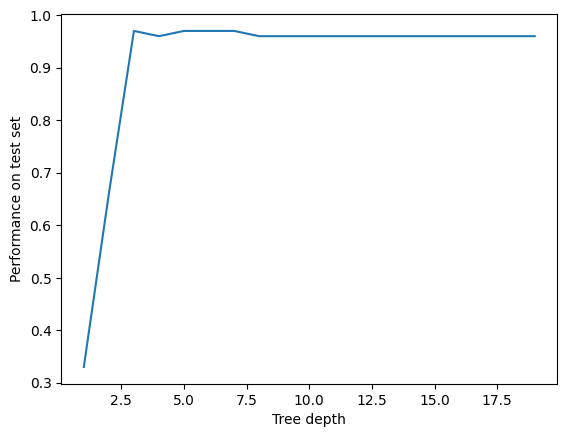

In [19]:
depths = []
accuracies = []
for depth in range(1, 20):
    model = DecisionTreeClassifier(max_depth=depth)
    model.fit(iris_train_x, iris_train_y)
    accuracy = (model.predict(iris_test_x) == iris_test_y).mean()
    accuracies.append(accuracy)
    depths.append(depth)

print("Best performance: ", max(accuracies))
plt.xlabel('Tree depth')
plt.ylabel('Performance on test set')
plt.plot(depths, accuracies)

## Random forest

Next, we will implement the random forest model using our decision tree. 

A random forest is an ensemble of decision trees, where each tree is trained by randomizing the dataset. The standard method for randomizing the dataset is feature bagging, where a random subset of features is selected for each tree, but other methods are possible.

We will explore two ways of randomizing the dataset: 1) feature bagging, and 2) example bagging, i.e. training each classifier on a random subset of the dataset.


In [20]:
import math

class RandomForestClassifier():
    def __init__(self, n_estimators=2, max_depth=5, bootstrap_fraction=0.5, features_fraction=0.5):
        self.max_depth = max_depth
        self.n_estimators = n_estimators
        self.bootstrap_fraction = bootstrap_fraction
        self.features_fraction= features_fraction
        self.estimators = []
        
    def fit(self, x, y):
        num_rows = math.ceil(self.bootstrap_fraction * x.shape[0])
        num_cols = math.ceil(self.features_fraction * x.shape[1])
        for _ in range(self.n_estimators):
            rows_idx = np.random.choice(x.shape[0], size=num_rows)
            cols_idx = np.random.choice(x.shape[1], size=num_cols, replace=False)
            # 
            # Create noisy subsets x_subset, y_subset here
            # 
            rows_idx = np.random.choice(x.shape[0],size=num_rows)
            cols_idx = np.random.choice(x.shape[1], size=num_cols, replace=False)
            x_subset = x[rows_idx][:, cols_idx]
            y_subset = y[rows_idx]
            tree = DecisionTreeClassifier(max_depth=self.max_depth)
            tree.fit(x_subset, y_subset)
            self.estimators.append((tree,cols_idx))
        
    def predict(self, x):
        #
        # Predict output using all estimators here
        allpreds = np.array([e.predict(x[:,cols]) for e, cols in self.estimators])
        predictions = np.array([get_majority_class(y) for y in allpreds.T])
        return predictions


Now let's look at the influence of these hyperparameters. First, let's plot the performance as a function of the number of trees when using feature bagging only. Next, let's try example bagging only. Then let's put them together.

/

Maintenant regardons l'influence de ces hyperparamètres. D'abord, traçons les performances en fonction du nombre d'arbres en utilisant uniquement le feature bagging (ensachage d'attributs). Ensuite, essayons l'example bagging (ensachage d'exemples). Finalement, combinons-les ensemble.



In [21]:
def validation_curve(bootstrap_fraction, features_fraction):
  tree_counts = []
  accuracies = []
  for tree_count in range(1, 20):
      model = RandomForestClassifier(n_estimators=tree_count,
                                    max_depth=3,
                                    bootstrap_fraction=bootstrap_fraction,
                                    features_fraction=features_fraction)
      model.fit(iris_train_x, iris_train_y)
      accuracy = (model.predict(iris_test_x) == iris_test_y).mean()
      accuracies.append(accuracy)
      tree_counts.append(tree_count)

  print("Best performance: ", max(accuracies))
  plt.xlabel('n_estimators')
  plt.ylabel('Performance on test set')
  plt.plot(tree_counts, accuracies)
  plt.show()

Best performance:  0.98


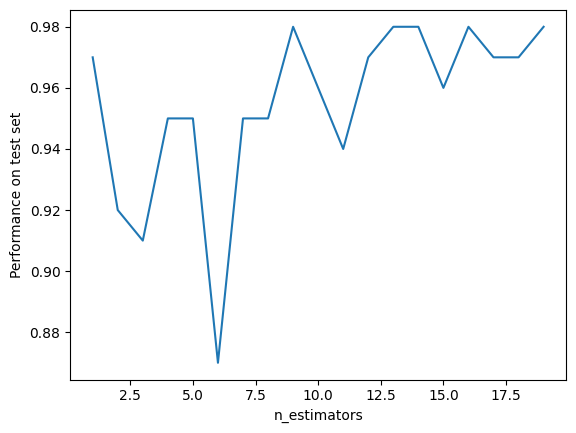

In [22]:
validation_curve(0.5,1)

Best performance:  0.98


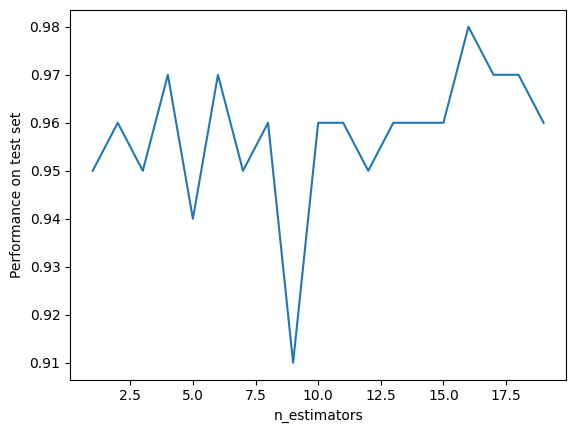

In [23]:
validation_curve(1, 0.5)

Best performance:  0.98


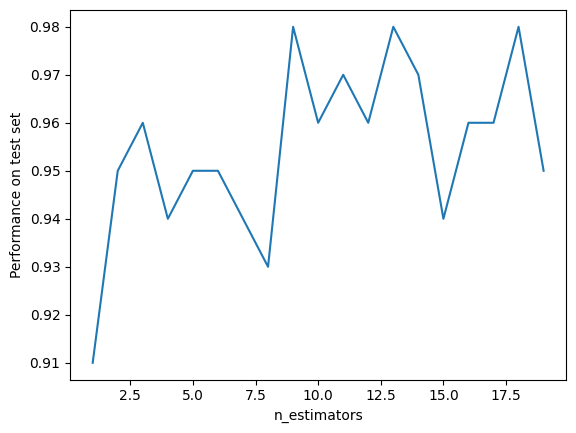

In [24]:
validation_curve(.5,.5)